# Lane Following

In this notebook we will build a Lane Follower agent.

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

VEHICLE_NAME: str = "kizzy"

In [2]:
## Real Duckiebot - KIZZY

import os
from duckietown.types import CameraParameters

if VEHICLE_NAME == "kizzy":
    CAMERA_PARAMETERS: CameraParameters = {
        "width": 640,
        "height": 480,
        "K": np.reshape(
            [
                275.73276038498926,
                0.0,
                319.6766909474663,
                0.0,
                280.1548497747509,
                273.2555774703665,
                0.0,
                0.0,
                1.0,
            ],
            (3, 3),
        ),
        "D": [
            -0.186769174617111,
            0.021237828783060932,
            -0.010063453683894804,
            0.0020176247114933833,
            0.0,
        ],
        "P": np.reshape(
            [
                181.33279418945312,
                0.0,
                321.308646777532,
                0.0,
                0.0,
                230.59254455566406,
                277.2216409396642,
                0.0,
                0.0,
                0.0,
                1.0,
                0.0,
            ],
            (3, 4),
        ),
        "H": np.reshape(
            [
                # 8.56148231e-03,
                # 2.22480148e-01,
                # 4.24318934e-01,
                # -5.67022044e-01,
                # -1.13258040e-03,
                # 6.81113839e-04,
                # 5.80917161e-02,
                # 4.35079347e00,
                # 1.0,

                0.0219712,
                0.09045404,
                0.38400369,
                -0.44468068,
                0.01655425,
                0.01499358,
                0.20360817,
                2.9932356,
                1.        
            ],
            (3, 3),
        ),
    }

    GAIN: float = 0.85
    TRIM: float = 0.08
    V_MAX: float = 1.0
    OMEGA_MAX: float = 8.0

In [3]:
# Sensor - Camera

from duckietown.components.duckiebot import CameraDriverComponent

camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME, compression="none", frequency=15)

Using ROS...


In [4]:
# Image Cropping

from duckietown.components.lane_following import ImageCropComponent

image_crop: ImageCropComponent = ImageCropComponent(parameters=CAMERA_PARAMETERS)

In [5]:
# Line Detector

from duckietown.components.lane_following import LineDetectorComponent

line_detector: LineDetectorComponent = LineDetectorComponent()

In [6]:
# Lane Filter

from duckietown.components.lane_following import LaneFilterComponent

lane_filter: LaneFilterComponent = LaneFilterComponent(camera_parameters=CAMERA_PARAMETERS)

In [7]:
# Lane Controller

from duckietown.components.lane_following import LaneControllerComponent

lane_controller: LaneControllerComponent = LaneControllerComponent()

In [8]:
# Inverse Kinematics

from duckietown.components.lane_following import InverseKinematicsComponent

inverse_kinematics: InverseKinematicsComponent = InverseKinematicsComponent(v_max=V_MAX, omega_max=OMEGA_MAX)

In [9]:
# PWM Mapper

from duckietown.components.lane_following import PWMComponent

pwm: PWMComponent = PWMComponent(gain=GAIN, trim=TRIM)

In [10]:
# Wheels Driver

from duckietown.components.duckiebot import MotorsDriverComponent

motors: MotorsDriverComponent = MotorsDriverComponent(vehicle_name=VEHICLE_NAME)

Using ROS...


In [11]:
# StopLine Detector

from duckietown.components.intersections import StopLineDetectorComponent

stopline_detector: StopLineDetectorComponent = StopLineDetectorComponent()

In [12]:
# Stopline LED Component

from duckietown.components.intersections import StopLineLEDComponent

stopline_led: StopLineLEDComponent = StopLineLEDComponent()

In [13]:
# ToF Driver Component

from duckietown.components.duckiebot import TimeOfFlightDriverComponent

tof: TimeOfFlightDriverComponent = TimeOfFlightDriverComponent(vehicle_name=VEHICLE_NAME, frequency=5)

Using ROS...


In [14]:
# Obstacle Avoidance

from duckietown.components.obstacles import ObstacleAvoidanceComponent

obstacle_avoidance: ObstacleAvoidanceComponent = ObstacleAvoidanceComponent()

In [15]:
# LED drivers

from duckietown.components.duckiebot import LEDsDriverComponent

leds: LEDsDriverComponent = LEDsDriverComponent(VEHICLE_NAME)

Using ROS...


In [16]:
# Driving Logic Component

from duckietown.components.logic import DrivingLogicComponent

logic: DrivingLogicComponent = DrivingLogicComponent(stop_data=(0.0, 0.0))

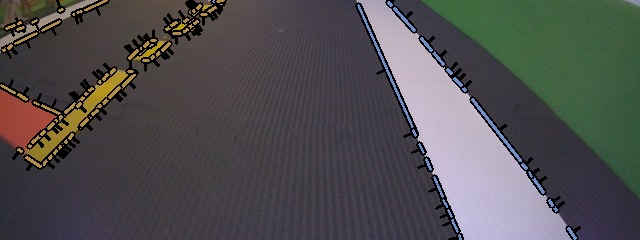

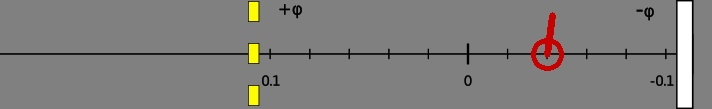

None

(0.13737766271928492, 0.26733978157431826)

In [17]:
# Rendering components

from duckietown.components.rendering import ImageRendererComponent, TextRendererComponent

# define components
detections: ImageRendererComponent = ImageRendererComponent(frequency=8)#, image_opts={"width": 1200})
segments: ImageRendererComponent = ImageRendererComponent(frequency=8)
belief: ImageRendererComponent = ImageRendererComponent(frequency=12)
pwm_signals: TextRendererComponent = TextRendererComponent()
text_viewer1: TextRendererComponent = TextRendererComponent()
text_viewer2: TextRendererComponent = TextRendererComponent()

In [18]:
# Clear components

image_crop.in_bgr.detach_all()

line_detector.in_bgr.detach_all()

lane_filter.in_lines.detach_all()
lane_filter.in_command_time.detach_all()
lane_filter.in_v_omega.detach_all()

lane_controller.in_d_phi.detach_all()

inverse_kinematics.in_v_omega.detach_all()

obstacle_avoidance.in_range.detach_all()

stopline_detector.in_segments.detach_all()
stopline_detector.in_d_phi.detach_all()

logic.in_data.detach_all()
logic.in_obstacle.detach_all()
logic.in_stopline.detach_all()

pwm.in_wl_wr.detach_all()

motors.in_pwml_pwmr.detach_all()

stopline_led.in_break.detach_all()

leds.in_pattern.detach_all()

# Rendering components

detections.in_image.detach_all()
segments.in_image.detach_all()
belief.in_image.detach_all()
pwm_signals.in_data.detach_all()

text_viewer1.in_data.detach_all()
text_viewer2.in_data.detach_all()

In [19]:
# Connect components

image_crop.in_bgr.wants(camera.out_bgr)

line_detector.in_bgr.wants(image_crop.out_bgr)

lane_filter.in_lines.wants(line_detector.out_lines)
# lane_filter.in_command_time.wants(motors.out_command_time)
# lane_filter.in_v_omega.wants(lane_controller.out_v_omega)

lane_controller.in_d_phi.wants(lane_filter.out_d_phi)

inverse_kinematics.in_v_omega.wants(lane_controller.out_v_omega)

# obstacle_avoidance.in_range.wants(tof.out_range)

# stopline_detector.in_segments.wants(lane_filter.out_segments)
# stopline_detector.in_d_phi.wants(lane_filter.out_d_phi)

logic.in_data.wants(inverse_kinematics.out_wl_wr)
# logic.in_obstacle.wants(obstacle_avoidance.out_obstacle)
# logic.in_stopline.wants(stopline_detector.out_stopline)

pwm.in_wl_wr.wants(logic.out_data)

motors.in_pwml_pwmr.wants(pwm.out_pwml_pwmr)

stopline_led.in_break.wants(logic.out_stopped)

leds.in_pattern.wants(stopline_led.out_pattern)

# Connect rendering components

# detections.in_image.wants(camera.out_bgr)
detections.in_image.wants(line_detector.out_lines_image)
# segments.in_image.wants(lane_filter.out_segments_image)
belief.in_image.wants(lane_filter.out_belief_image)
# pwm_signals.in_data.wants(pwm.out_pwml_pwmr)

text_viewer1.in_data.wants(tof.out_range)
# text_viewer1.in_data.wants(obstacle_avoidance.out_obstacle)
# text_viewer1.in_data.wants(stopline_detector.out_stopline)
# text_viewer2.in_data.wants(stopline_led.out_pattern)

text_viewer2.in_data.wants(pwm.out_pwml_pwmr)

In [20]:
# Drive button

from IPython.display import display
import ipywidgets as widgets
drive: bool = False

def clicked(arg):
    global drive
    print(f"Drive: {drive}")
    if drive:
        motors.in_pwml_pwmr.wants(pwm.out_pwml_pwmr)
    else:
        motors.in_pwml_pwmr.detach(pwm.out_pwml_pwmr)
    drive = not drive

button_download = widgets.Button(description = 'Toggle Drive')   
button_download.on_click(clicked)
display(button_download)

Button(description='Toggle Drive', style=ButtonStyle())

In [33]:
# Lane Following

import time
from typing import List

from duckietown.components.base import Component
from duckietown.system import System

# stopline_detector._stop_distance = 0.25
# stopline_detector._min_segs = 6
# stopline_detector._max_y = 0.10

pwm._pwm.gain = 0.85
pwm._pwm.trim = 0.08

# list of components to run
components: List[Component] = [
    camera,
    image_crop,
    line_detector,
    lane_filter,
    lane_controller,
    inverse_kinematics,
    pwm,
    logic,
    tof,
    obstacle_avoidance,
    # stopline_detector,
    stopline_led,
    leds,
    motors,
    # -- rendering
    detections,
    segments,
    belief,
    # pwm_signals,
    text_viewer1,
    text_viewer2,
]

# create system
system: System = System(components)

# run system (NOTE: this is blocking)
system.run()

[system]: System booting...
[system]: Component CameraDriverComponent@139804815573392 started!
[system]: Component ImageCropComponent@139804815544528 started!
[system]: Component LineDetectorComponent@139804815573104 started!
[system]: Component LaneFilterComponent@139804019617168 started!
[system]: Component LaneControllerComponent@139804025494160 started!
[system]: Component InverseKinematicsComponent@139803707580624 started!
[system]: Component PWMComponent@139803707580768 started!
[system]: Component DrivingLogicComponent@139804270499632 started!
[system]: Component TimeOfFlightDriverComponent@139803958167152 started!
[system]: Component ObstacleAvoidanceComponent@139803707582832 started!
[system]: Component StopLineLEDComponent@139803707506064 started!
[system]: Component LEDsDriverComponent@139803958169216 started!
[system]: Component MotorsDriverComponent@139804815576848 started!
[system]: Component ImageRendererComponent@139803958259968 started!
[system]: Component ImageRendere

[system]: Stopping component CameraDriverComponent@139804815573392...
[system]: Stopping component ImageCropComponent@139804815544528...
[system]: Stopping component LineDetectorComponent@139804815573104...
[system]: Stopping component LaneFilterComponent@139804019617168...
[system]: Stopping component LaneControllerComponent@139804025494160...
[system]: Stopping component InverseKinematicsComponent@139803707580624...
[system]: Stopping component PWMComponent@139803707580768...
[system]: Stopping component DrivingLogicComponent@139804270499632...
[system]: Stopping component TimeOfFlightDriverComponent@139803958167152...
[system]: Stopping component ObstacleAvoidanceComponent@139803707582832...
[system]: Stopping component StopLineLEDComponent@139803707506064...
[system]: Stopping component LEDsDriverComponent@139803958169216...
[system]: Stopping component MotorsDriverComponent@139804815576848...
[system]: Stopping component ImageRendererComponent@139803958259968...
[system]: Stopping